We save the model with model.save("ising_4x4.keras") so we don't have to retrain. We can load this model again with
```
model = tf.keras.models.load_model("ising_4x4.keras")
```

# L = 4

## Extract raw data and separate into training and testing datasets

In [3]:
class_names = ['Below T_c', 'Above T_c']
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full4x4"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000
TRAIN_BINS = int(0.8 * NUM_BINS)
TEST_BINS = int(0.2 * NUM_BINS)
NUM_TRAIN = int(TRAIN_BINS * NUM_TEMPS)
NUM_TEST = int(TEST_BINS * NUM_TEMPS)

L = 4

file_string = "../data/spinconfigs/spinConfigs_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_spin_configs = np.zeros(shape=(NUM_TEMPS, NUM_BINS, L, L))

data_dict = {}

# initialize data dictionary
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = []

# convert -1s to 0s
for entry in data:
    for index in range(L*L):
        if entry[index] == -1:
            entry[index] = 0

# extract spin configs values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):            
        raw_spin_configs[temp][bin] = data[(temp * NUM_BINS) + bin].reshape(L, L)

# populate data dictionary with numpy array of temps
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = raw_spin_configs[temp]

# initialize arrays for training and testing images and labels
train_images = np.zeros(shape=(NUM_TRAIN, L, L))
shuffled_images = train_images

train_labels = np.zeros(NUM_TRAIN, dtype=int)
shuffled_labels = train_labels

test_images = np.zeros(shape=(NUM_TEST, L, L))
shuffled_test_images = test_images

test_labels = np.zeros(NUM_TEST, dtype=int)
shuffled_test_labels = test_labels


# populate train images and train labels with spin configs
offset = 0
for temp, array in data_dict.items():
    train_images[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = array[0:TRAIN_BINS]
    test_images[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = array[TRAIN_BINS:]
    
    # if lower than T_c, should be a 0
    if temp < 2.269:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.zeros(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.zeros(TEST_BINS)
    else:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.ones(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.ones(TEST_BINS)
    
    offset += 1

# helper function to shuffle pairs of images
def shuffle_pairs(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# shuffle our images and labels according to the same permutation
shuffled_images, shuffled_labels = shuffle_pairs(train_images, train_labels)

# shuffle test images and labels
shuffled_test_images, shuffled_test_labels = shuffle_pairs(test_images, test_labels)

square_data_dict = {}

# reshape dictionary arrays into LxL instead of 
for temp in range(NUM_TEMPS):
    square_data_dict[TEMP_VALS[temp]] = data_dict[TEMP_VALS[temp]].reshape(NUM_BINS, L, L)

## Train model for Ising 4x4

In [4]:
import tensorflow as tf

ising4x4model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(L, L)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

ising4x4model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ising4x4model.fit(shuffled_images, shuffled_labels, epochs=20)

Epoch 1/20
6500/6500 [==============================] - 5s 813us/step - loss: 0.5238 - accuracy: 0.7573
Epoch 2/20
6500/6500 [==============================] - 4s 603us/step - loss: 0.5032 - accuracy: 0.7668
Epoch 3/20
6500/6500 [==============================] - 4s 592us/step - loss: 0.5007 - accuracy: 0.7684
Epoch 4/20
6500/6500 [==============================] - 4s 592us/step - loss: 0.4990 - accuracy: 0.7688
Epoch 5/20
6500/6500 [==============================] - 4s 588us/step - loss: 0.5028 - accuracy: 0.7673
Epoch 6/20
6500/6500 [==============================] - 4s 590us/step - loss: 0.4999 - accuracy: 0.7683
Epoch 7/20
6500/6500 [==============================] - 4s 585us/step - loss: 0.5006 - accuracy: 0.7678
Epoch 8/20
6500/6500 [==============================] - 4s 587us/step - loss: 0.4981 - accuracy: 0.7685
Epoch 9/20
6500/6500 [==============================] - 4s 585us/step - loss: 0.5012 - accuracy: 0.7656
Epoch 10/20
6500/6500 [==============================] - 4s 590u

In [5]:
ising4x4model.save("ising4x4.keras")

In [6]:
test_loss, test_acc = ising4x4model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([ising4x4model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

1625/1625 - 1s - loss: 0.5062 - accuracy: 0.7661

Test accuracy: 0.7661346197128296


In [9]:
raw_confidence_above_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))
raw_confidence_below_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))

confidence_above_ising4x4 = []
confidence_below_ising4x4 = []
error_above_ising4x4 = []
error_below_ising4x4 = []

for temp in range(NUM_TEMPS):
    for bin in range(TEST_BINS):
        raw_confidence_above_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][1])
        raw_confidence_below_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][0])

    error_above_ising4x4.append(np.std(raw_confidence_above_vals[temp]) / np.sqrt(TEST_BINS))
    error_below_ising4x4.append(np.std(raw_confidence_below_vals[temp]) / np.sqrt(TEST_BINS))
    
    confidence_above_ising4x4.append(np.mean(raw_confidence_above_vals[temp]))
    confidence_below_ising4x4.append(np.mean(raw_confidence_below_vals[temp]))

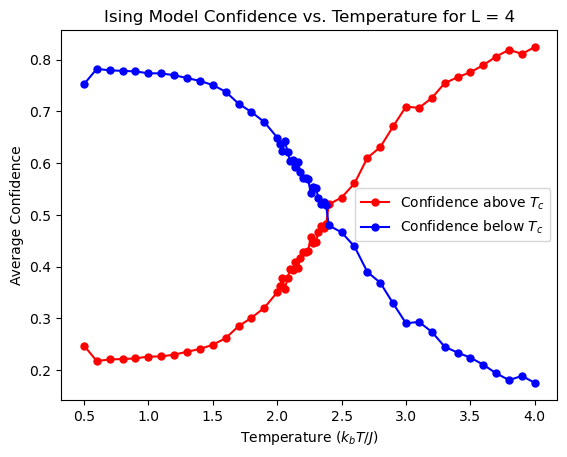

In [10]:
plt.plot(TEMP_VALS, confidence_above_ising4x4, label="Confidence above $T_{c}$", marker=".", markersize=10, color="r")
plt.plot(TEMP_VALS, confidence_below_ising4x4, label="Confidence below $T_{c}$", marker=".", markersize=10, color="b")
plt.title("Ising Model Confidence vs. Temperature for L = 4")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Average Confidence")
plt.legend()
#plt.savefig("ising_confidence_vs_t.png")
plt.show()

## Produce magnetization plot

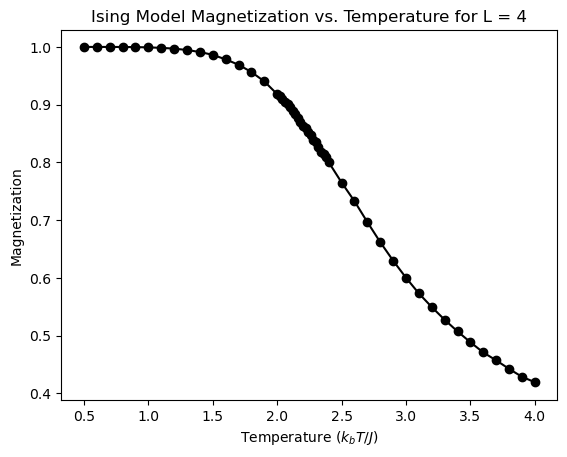

In [1]:
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full4x4"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000

file_string = "../data/bins/bins_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_magnetization_vals = np.zeros(shape=(NUM_TEMPS, NUM_BINS))
magnetization_errors = np.zeros(NUM_TEMPS)

data_dict = {}

# extract magnetization values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):
        raw_magnetization_vals[temp][bin] = float(data[(temp * NUM_BINS) + bin][-1])

    data_dict[TEMP_VALS[temp]] = np.mean(raw_magnetization_vals[temp])
    magnetization_errors[temp] = np.std(raw_magnetization_vals[temp]) / np.sqrt(NUM_BINS)

temps = []
magnetizations = []

# iterate through dictionary of data to facilitate plotting
for temp, magnetization in data_dict.items():
    temps.append(temp)
    magnetizations.append(magnetization)

magnetization_vals_4 = magnetizations
magnetizations_errors_4 = magnetization_errors

plt.errorbar(temps, magnetizations, magnetization_errors, marker=".", markersize=12, color="k")
plt.title("Ising Model Magnetization vs. Temperature for L = 4")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Magnetization")
#plt.savefig('ising_magnetization_L=4.png')
plt.show()

# Repeat for L = 8

In [11]:
class_names = ['Below T_c', 'Above T_c']
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full8x8"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000
TRAIN_BINS = int(0.8 * NUM_BINS)
TEST_BINS = int(0.2 * NUM_BINS)
NUM_TRAIN = int(TRAIN_BINS * NUM_TEMPS)
NUM_TEST = int(TEST_BINS * NUM_TEMPS)

L = 8

file_string = "../data/spinconfigs/spinConfigs_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_spin_configs = np.zeros(shape=(NUM_TEMPS, NUM_BINS, L, L))

data_dict = {}

# initialize data dictionary
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = []

# convert -1s to 0s
for entry in data:
    for index in range(L*L):
        if entry[index] == -1:
            entry[index] = 0

# extract spin configs values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):            
        raw_spin_configs[temp][bin] = data[(temp * NUM_BINS) + bin].reshape(L, L)

# populate data dictionary with numpy array of temps
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = raw_spin_configs[temp]

# initialize arrays for training and testing images and labels
train_images = np.zeros(shape=(NUM_TRAIN, L, L))
shuffled_images = train_images

train_labels = np.zeros(NUM_TRAIN, dtype=int)
shuffled_labels = train_labels

test_images = np.zeros(shape=(NUM_TEST, L, L))
shuffled_test_images = test_images

test_labels = np.zeros(NUM_TEST, dtype=int)
shuffled_test_labels = test_labels


# populate train images and train labels with spin configs
offset = 0
for temp, array in data_dict.items():
    train_images[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = array[0:TRAIN_BINS]
    test_images[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = array[TRAIN_BINS:]
    
    # if lower than T_c, should be a 0
    if temp < 2.269:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.zeros(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.zeros(TEST_BINS)
    else:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.ones(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.ones(TEST_BINS)
    
    offset += 1

# helper function to shuffle pairs of images
def shuffle_pairs(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# shuffle our images and labels according to the same permutation
shuffled_images, shuffled_labels = shuffle_pairs(train_images, train_labels)

# shuffle test images and labels
shuffled_test_images, shuffled_test_labels = shuffle_pairs(test_images, test_labels)

square_data_dict = {}

# reshape dictionary arrays into LxL instead of 
for temp in range(NUM_TEMPS):
    square_data_dict[TEMP_VALS[temp]] = data_dict[TEMP_VALS[temp]].reshape(NUM_BINS, L, L)

In [12]:
import tensorflow as tf

ising8x8model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(L, L)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

ising8x8model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ising8x8model.fit(shuffled_images, shuffled_labels, epochs=20)

Epoch 1/20
6500/6500 [==============================] - 4s 583us/step - loss: 0.3734 - accuracy: 0.8397
Epoch 2/20
6500/6500 [==============================] - 4s 584us/step - loss: 0.3335 - accuracy: 0.8536
Epoch 3/20
6500/6500 [==============================] - 4s 582us/step - loss: 0.3268 - accuracy: 0.8566
Epoch 4/20
6500/6500 [==============================] - 4s 585us/step - loss: 0.3242 - accuracy: 0.8567
Epoch 5/20
6500/6500 [==============================] - 4s 590us/step - loss: 0.3194 - accuracy: 0.8601
Epoch 6/20
6500/6500 [==============================] - 4s 586us/step - loss: 0.3176 - accuracy: 0.8593
Epoch 7/20
6500/6500 [==============================] - 4s 596us/step - loss: 0.3158 - accuracy: 0.8610
Epoch 8/20
6500/6500 [==============================] - 4s 588us/step - loss: 0.3142 - accuracy: 0.8630
Epoch 9/20
6500/6500 [==============================] - 4s 593us/step - loss: 0.3112 - accuracy: 0.8648
Epoch 10/20
6500/6500 [==============================] - 4s 579u

In [13]:
ising8x8model.save("ising8x8.keras")

In [14]:
test_loss, test_acc = ising8x8model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([ising8x8model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

1625/1625 - 1s - loss: 0.3315 - accuracy: 0.8541

Test accuracy: 0.8541346192359924


In [15]:
raw_confidence_above_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))
raw_confidence_below_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))

confidence_above_ising8x8 = []
confidence_below_ising8x8 = []
error_above_ising8x8 = []
error_below_ising8x8 = []

for temp in range(NUM_TEMPS):
    for bin in range(TEST_BINS):
        raw_confidence_above_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][1])
        raw_confidence_below_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][0])

    error_above_ising8x8.append(np.std(raw_confidence_above_vals[temp]) / np.sqrt(TEST_BINS))
    error_below_ising8x8.append(np.std(raw_confidence_below_vals[temp]) / np.sqrt(TEST_BINS))
    
    confidence_above_ising8x8.append(np.mean(raw_confidence_above_vals[temp]))
    confidence_below_ising8x8.append(np.mean(raw_confidence_below_vals[temp]))

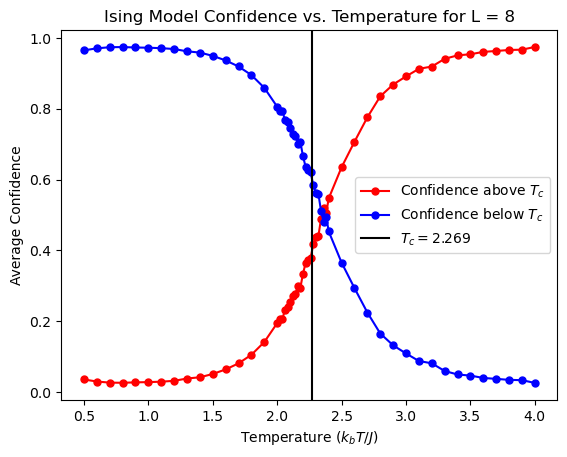

In [17]:
plt.plot(TEMP_VALS, confidence_above_ising8x8, label="Confidence above $T_{c}$", marker=".", markersize=10, color="r")
plt.plot(TEMP_VALS, confidence_below_ising8x8, label="Confidence below $T_{c}$", marker=".", markersize=10, color="b")
plt.title("Ising Model Confidence vs. Temperature for L = 8")
plt.axvline(x = 2.269, color = 'k', label="$T_{c} = 2.269$")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Average Confidence")
plt.legend()
#plt.savefig("ising_confidence_vs_t.png")
plt.show()

## Produce Magnetization Plot

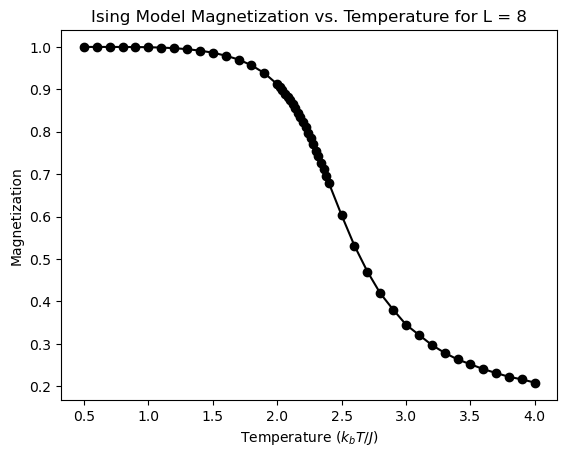

In [2]:
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full8x8"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000

file_string = "../data/bins/bins_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_magnetization_vals = np.zeros(shape=(NUM_TEMPS, NUM_BINS))
magnetization_errors = np.zeros(NUM_TEMPS)

data_dict = {}

# extract magnetization values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):
        raw_magnetization_vals[temp][bin] = float(data[(temp * NUM_BINS) + bin][-1])

    data_dict[TEMP_VALS[temp]] = np.mean(raw_magnetization_vals[temp])
    magnetization_errors[temp] = np.std(raw_magnetization_vals[temp]) / np.sqrt(NUM_BINS)

temps = []
magnetizations = []

# iterate through dictionary of data to facilitate plotting
for temp, magnetization in data_dict.items():
    temps.append(temp)
    magnetizations.append(magnetization)

magnetization_vals_8 = magnetizations
magnetizations_errors_8 = magnetization_errors

plt.errorbar(temps, magnetizations, magnetization_errors, marker=".", markersize=12, color="k")
plt.title("Ising Model Magnetization vs. Temperature for L = 8")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Magnetization")
#plt.savefig('ising_magnetization_L=4.png')
plt.show()

# Repeat for L = 16

In [18]:
class_names = ['Below T_c', 'Above T_c']
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full16x16"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000
TRAIN_BINS = int(0.8 * NUM_BINS)
TEST_BINS = int(0.2 * NUM_BINS)
NUM_TRAIN = int(TRAIN_BINS * NUM_TEMPS)
NUM_TEST = int(TEST_BINS * NUM_TEMPS)

L = 16

file_string = "../data/spinconfigs/spinConfigs_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_spin_configs = np.zeros(shape=(NUM_TEMPS, NUM_BINS, L, L))

data_dict = {}

# initialize data dictionary
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = []

# convert -1s to 0s
for entry in data:
    for index in range(L*L):
        if entry[index] == -1:
            entry[index] = 0

# extract spin configs values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):            
        raw_spin_configs[temp][bin] = data[(temp * NUM_BINS) + bin].reshape(L, L)

# populate data dictionary with numpy array of temps
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = raw_spin_configs[temp]

# initialize arrays for training and testing images and labels
train_images = np.zeros(shape=(NUM_TRAIN, L, L))
shuffled_images = train_images

train_labels = np.zeros(NUM_TRAIN, dtype=int)
shuffled_labels = train_labels

test_images = np.zeros(shape=(NUM_TEST, L, L))
shuffled_test_images = test_images

test_labels = np.zeros(NUM_TEST, dtype=int)
shuffled_test_labels = test_labels


# populate train images and train labels with spin configs
offset = 0
for temp, array in data_dict.items():
    train_images[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = array[0:TRAIN_BINS]
    test_images[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = array[TRAIN_BINS:]
    
    # if lower than T_c, should be a 0
    if temp < 2.269:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.zeros(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.zeros(TEST_BINS)
    else:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.ones(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.ones(TEST_BINS)
    
    offset += 1

# helper function to shuffle pairs of images
def shuffle_pairs(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# shuffle our images and labels according to the same permutation
shuffled_images, shuffled_labels = shuffle_pairs(train_images, train_labels)

# shuffle test images and labels
shuffled_test_images, shuffled_test_labels = shuffle_pairs(test_images, test_labels)

square_data_dict = {}

# reshape dictionary arrays into LxL instead of 
for temp in range(NUM_TEMPS):
    square_data_dict[TEMP_VALS[temp]] = data_dict[TEMP_VALS[temp]].reshape(NUM_BINS, L, L)

In [19]:
import tensorflow as tf

ising16x16model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(L, L)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

ising16x16model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ising16x16model.fit(shuffled_images, shuffled_labels, epochs=20)

Epoch 1/20
6500/6500 [==============================] - 4s 583us/step - loss: 0.2865 - accuracy: 0.8865
Epoch 2/20
6500/6500 [==============================] - 4s 577us/step - loss: 0.2229 - accuracy: 0.9089
Epoch 3/20
6500/6500 [==============================] - 4s 586us/step - loss: 0.2082 - accuracy: 0.9137
Epoch 4/20
6500/6500 [==============================] - 4s 570us/step - loss: 0.1989 - accuracy: 0.9176
Epoch 5/20
6500/6500 [==============================] - 4s 577us/step - loss: 0.1913 - accuracy: 0.9210
Epoch 6/20
6500/6500 [==============================] - 4s 597us/step - loss: 0.1825 - accuracy: 0.9239
Epoch 7/20
6500/6500 [==============================] - 4s 596us/step - loss: 0.1762 - accuracy: 0.9273
Epoch 8/20
6500/6500 [==============================] - 4s 587us/step - loss: 0.1695 - accuracy: 0.9293
Epoch 9/20
6500/6500 [==============================] - 4s 583us/step - loss: 0.1625 - accuracy: 0.9337
Epoch 10/20
6500/6500 [==============================] - 4s 596u

In [20]:
ising16x16model.save("ising16x16.keras")

In [21]:
test_loss, test_acc = ising16x16model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([ising16x16model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

1625/1625 - 1s - loss: 0.3190 - accuracy: 0.8950

Test accuracy: 0.8949999809265137


In [22]:
raw_confidence_above_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))
raw_confidence_below_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))

confidence_above_ising16x16 = []
confidence_below_ising16x16 = []
error_above_ising16x16 = []
error_below_ising16x16 = []

for temp in range(NUM_TEMPS):
    for bin in range(TEST_BINS):
        raw_confidence_above_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][1])
        raw_confidence_below_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][0])

    error_above_ising16x16.append(np.std(raw_confidence_above_vals[temp]) / np.sqrt(TEST_BINS))
    error_below_ising16x16.append(np.std(raw_confidence_below_vals[temp]) / np.sqrt(TEST_BINS))
    
    confidence_above_ising16x16.append(np.mean(raw_confidence_above_vals[temp]))
    confidence_below_ising16x16.append(np.mean(raw_confidence_below_vals[temp]))

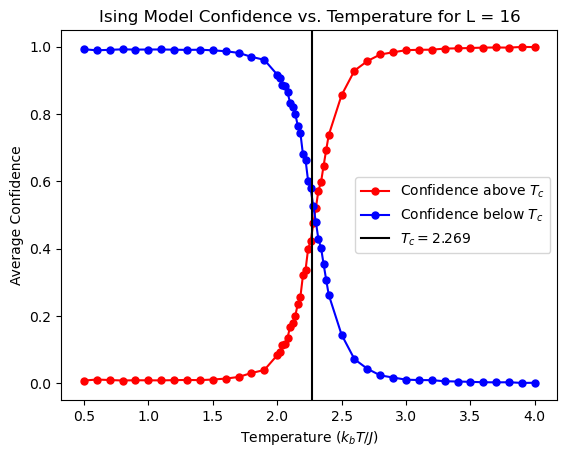

In [23]:
plt.plot(TEMP_VALS, confidence_above_ising16x16, label="Confidence above $T_{c}$", marker=".", markersize=10, color="r")
plt.plot(TEMP_VALS, confidence_below_ising16x16, label="Confidence below $T_{c}$", marker=".", markersize=10, color="b")
plt.title("Ising Model Confidence vs. Temperature for L = 16")
plt.axvline(x = 2.269, color = 'k', label="$T_{c} = 2.269$")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Average Confidence")
plt.legend()
plt.savefig("ising_confidence_vs_t_16x16.png", dpi=500)
plt.show()

## Produce Magnetization Plot

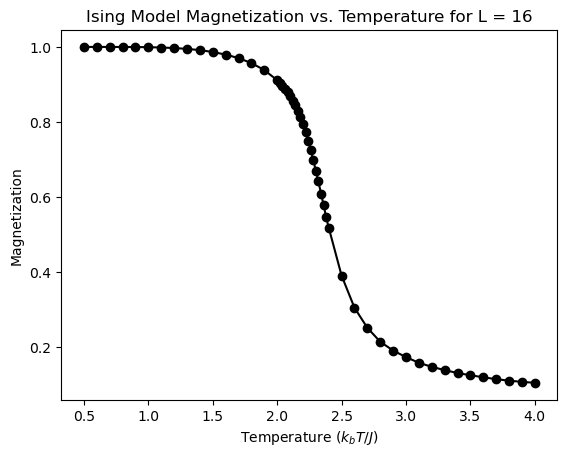

In [3]:
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full16x16"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000

file_string = "../data/bins/bins_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_magnetization_vals = np.zeros(shape=(NUM_TEMPS, NUM_BINS))
magnetization_errors = np.zeros(NUM_TEMPS)

data_dict = {}

# extract magnetization values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):
        raw_magnetization_vals[temp][bin] = float(data[(temp * NUM_BINS) + bin][-1])

    data_dict[TEMP_VALS[temp]] = np.mean(raw_magnetization_vals[temp])
    magnetization_errors[temp] = np.std(raw_magnetization_vals[temp]) / np.sqrt(NUM_BINS)

temps = []
magnetizations = []

# iterate through dictionary of data to facilitate plotting
for temp, magnetization in data_dict.items():
    temps.append(temp)
    magnetizations.append(magnetization)

magnetization_vals_16 = magnetizations
magnetizations_errors_16 = magnetization_errors

plt.errorbar(temps, magnetizations, magnetization_errors, marker=".", markersize=12, color="k")
plt.title("Ising Model Magnetization vs. Temperature for L = 16")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Magnetization")
#plt.savefig('ising_magnetization_L=4.png')
plt.show()

## Producing plots of confidence vs. $\Delta t$ for Ising Model with L = 8

In [2]:
class_names = ['Below T_c', 'Above T_c']
import matplotlib.pyplot as plt
import numpy as np

### Extra all the raw spins
Here we look at our "isingdeltaT" file. We want to train a model on each of the different $\Delta t$ options

In [5]:
FILENAME = "isingvsT"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 1000
TRAIN_BINS = int(0.8 * NUM_BINS)
TEST_BINS = int(0.2 * NUM_BINS)
NUM_TRAIN = int(TRAIN_BINS * 2)
NUM_TEST = int(TEST_BINS * 2)
DELTA_T_VALS = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5]
NUM_DELTA_T = len(DELTA_T_VALS)

L = 8

file_string = "../data/spinconfigs/spinConfigs_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_spin_configs = np.zeros(shape=(NUM_TEMPS, NUM_BINS, L, L))

data_dict = {}

# initialize data dictionary
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = []

# convert -1s to 0s
for entry in data:
    for index in range(L*L):
        if entry[index] == -1:
            entry[index] = 0

# extract spin configs values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):            
        raw_spin_configs[temp][bin] = data[(temp * NUM_BINS) + bin].reshape(L, L)

# populate data dictionary with numpy array of temps
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = raw_spin_configs[temp]

# initialize dictionary to store pairs of temps for training on delta T
deltaT_dict = {}

for temp in DELTA_T_VALS:
    deltaT_dict[temp] = []

train_images_01 = np.zeros(shape=(NUM_TRAIN, L, L))
shuffled_images_01 = train_images_01

train_labels_01 = np.zeros(NUM_TRAIN, dtype=int)
shuffled_labels_01 = train_labels

test_images_01 = np.zeros(shape=(NUM_TEST, L, L))
shuffled_test_images_01 = test_images_01

test_labels_01 = np.zeros(NUM_TEST, dtype=int)
shuffled_test_labels_01 = test_labels_01

train_images_01[:TRAIN_BINS] = data_dict[2.2][0:TRAIN_BINS]
train_images_01[TRAIN_BINS:] = data_dict[2.3][0:TRAIN_BINS]

test_images_01[:TEST_BINS] = data_dict[2.2][TRAIN_BINS:]
test_images_01[TEST_BINS:] = data_dict[2.3][TRAIN_BINS:]

train_labels_01[:TRAIN_BINS] = np.zeros(TRAIN_BINS)
train_labels_01[TRAIN_BINS:] = np.ones(TRAIN_BINS)

test_labels_01[:TEST_BINS] = np.zeros(TEST_BINS)
test_labels_01[TEST_BINS:] = np.ones(TEST_BINS)

def shuffle_pairs(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# shuffle our images and labels according to the same permutation
shuffled_images_01, shuffled_labels_01 = shuffle_pairs(train_images_01, train_labels_01)

# shuffle test images and labels
shuffled_test_images_01, shuffled_test_labels_01 = shuffle_pairs(test_images_01, test_labels_01)

square_data_dict = {}

# reshape dictionary arrays into LxL instead of 
for temp in range(NUM_TEMPS):
    square_data_dict[TEMP_VALS[temp]] = data_dict[TEMP_VALS[temp]].reshape(NUM_BINS, L, L)

In [6]:
import tensorflow as tf

model_01 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(L, L)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

model_01.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_01.fit(shuffled_images_01, shuffled_labels_01, epochs=10)

2024-04-05 10:44:54.770298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 10:44:57.665696: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
50/50 [==============================] - 1s 2ms/step - loss: 0.6997 - accuracy: 0.5125
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5581
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6761 - accuracy: 0.5738
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.6037
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.6094
Epoch 6/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6511 - accuracy: 0.6200
Epoch 7/10
50/50 [==============================] - 0s 3ms/step - loss: 0.6412 - accuracy: 0.6494
Epoch 8/10
50/50 [==============================] - 0s 3ms/step - loss: 0.6378 - accuracy: 0.6425
Epoch 9/10
50/50 [==============================] - 0s 3ms/step - loss: 0.6245 - accuracy: 0.6631
Epoch 10/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 0.6725


In [7]:
test_loss, test_acc = model_01.evaluate(test_images_01, test_labels_01, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model_01 = tf.keras.Sequential([model_01, 
                                         tf.keras.layers.Softmax()])

predictions_01 = probability_model_01.predict(test_images_01)

13/13 - 0s - loss: 0.7334 - accuracy: 0.5125 - 284ms/epoch - 22ms/step

Test accuracy: 0.512499988079071
13/13 [==============================] - 0s 2ms/step


In [8]:
print(len(predictions_01))

400


In [ ]:
confidence_above_dict = {}
confidence_below_dict = {}

raw_confidence_above_vals = np.zeros(shape=(18, TEST_BINS))
raw_confidence_below_vals = np.zeros(shape=(18, TEST_BINS))

confidence_above = []
confidence_below = []

for temp in range(NUM_DELTA_T):
    for bin in range(TEST_BINS):
        raw_confidence_above_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][1])
        raw_confidence_below_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][0])

    confidence_above_dict[TEMP_VALS[temp]] = np.mean(raw_confidence_above_vals[temp])
    confidence_below_dict[TEMP_VALS[temp]] = np.mean(raw_confidence_below_vals[temp])
    confidence_above.append(np.mean(raw_confidence_above_vals[temp]))
    confidence_below.append(np.mean(raw_confidence_below_vals[temp]))

# L = 32

In [24]:
class_names = ['Below T_c', 'Above T_c']
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full32x32"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000
TRAIN_BINS = int(0.8 * NUM_BINS)
TEST_BINS = int(0.2 * NUM_BINS)
NUM_TRAIN = int(TRAIN_BINS * NUM_TEMPS)
NUM_TEST = int(TEST_BINS * NUM_TEMPS)

L = 32

file_string = "../data/spinconfigs/spinConfigs_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_spin_configs = np.zeros(shape=(NUM_TEMPS, NUM_BINS, L, L))

data_dict = {}

# initialize data dictionary
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = []

# convert -1s to 0s
for entry in data:
    for index in range(L*L):
        if entry[index] == -1:
            entry[index] = 0

# extract spin configs values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):            
        raw_spin_configs[temp][bin] = data[(temp * NUM_BINS) + bin].reshape(L, L)

# populate data dictionary with numpy array of temps
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = raw_spin_configs[temp]

# initialize arrays for training and testing images and labels
train_images = np.zeros(shape=(NUM_TRAIN, L, L))
shuffled_images = train_images

train_labels = np.zeros(NUM_TRAIN, dtype=int)
shuffled_labels = train_labels

test_images = np.zeros(shape=(NUM_TEST, L, L))
shuffled_test_images = test_images

test_labels = np.zeros(NUM_TEST, dtype=int)
shuffled_test_labels = test_labels


# populate train images and train labels with spin configs
offset = 0
for temp, array in data_dict.items():
    train_images[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = array[0:TRAIN_BINS]
    test_images[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = array[TRAIN_BINS:]
    
    # if lower than T_c, should be a 0
    if temp < 2.269:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.zeros(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.zeros(TEST_BINS)
    else:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.ones(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.ones(TEST_BINS)
    
    offset += 1

# helper function to shuffle pairs of images
def shuffle_pairs(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# shuffle our images and labels according to the same permutation
shuffled_images, shuffled_labels = shuffle_pairs(train_images, train_labels)

# shuffle test images and labels
shuffled_test_images, shuffled_test_labels = shuffle_pairs(test_images, test_labels)

square_data_dict = {}

# reshape dictionary arrays into LxL instead of 
for temp in range(NUM_TEMPS):
    square_data_dict[TEMP_VALS[temp]] = data_dict[TEMP_VALS[temp]].reshape(NUM_BINS, L, L)

In [25]:
import tensorflow as tf

ising32x32model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(L, L)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

ising32x32model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ising32x32model.fit(shuffled_images, shuffled_labels, epochs=20)

Epoch 1/20
6500/6500 [==============================] - 5s 727us/step - loss: 0.2908 - accuracy: 0.8840
Epoch 2/20
6500/6500 [==============================] - 5s 724us/step - loss: 0.1521 - accuracy: 0.9472
Epoch 3/20
6500/6500 [==============================] - 5s 713us/step - loss: 0.1261 - accuracy: 0.9546
Epoch 4/20
6500/6500 [==============================] - 5s 814us/step - loss: 0.1105 - accuracy: 0.9592
Epoch 5/20
6500/6500 [==============================] - 5s 830us/step - loss: 0.0993 - accuracy: 0.9635
Epoch 6/20
6500/6500 [==============================] - 5s 779us/step - loss: 0.0903 - accuracy: 0.9663
Epoch 7/20
6500/6500 [==============================] - 5s 763us/step - loss: 0.0809 - accuracy: 0.9693
Epoch 8/20
6500/6500 [==============================] - 5s 808us/step - loss: 0.0752 - accuracy: 0.9711
Epoch 9/20
6500/6500 [==============================] - 5s 726us/step - loss: 0.0707 - accuracy: 0.9734
Epoch 10/20
6500/6500 [==============================] - 5s 815u

In [26]:
ising32x32model.save("ising32x32.keras")

In [27]:
test_loss, test_acc = ising32x32model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([ising32x32model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

raw_confidence_above_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))
raw_confidence_below_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))

confidence_above_ising32x32 = []
confidence_below_ising32x32 = []
error_above_ising32x32 = []
error_below_ising32x32 = []

for temp in range(NUM_TEMPS):
    for bin in range(TEST_BINS):
        raw_confidence_above_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][1])
        raw_confidence_below_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][0])

    error_above_ising32x32.append(np.std(raw_confidence_above_vals[temp]) / np.sqrt(TEST_BINS))
    error_below_ising32x32.append(np.std(raw_confidence_below_vals[temp]) / np.sqrt(TEST_BINS))
    
    confidence_above_ising32x32.append(np.mean(raw_confidence_above_vals[temp]))
    confidence_below_ising32x32.append(np.mean(raw_confidence_below_vals[temp]))

1625/1625 - 1s - loss: 0.3313 - accuracy: 0.9387

Test accuracy: 0.938730776309967


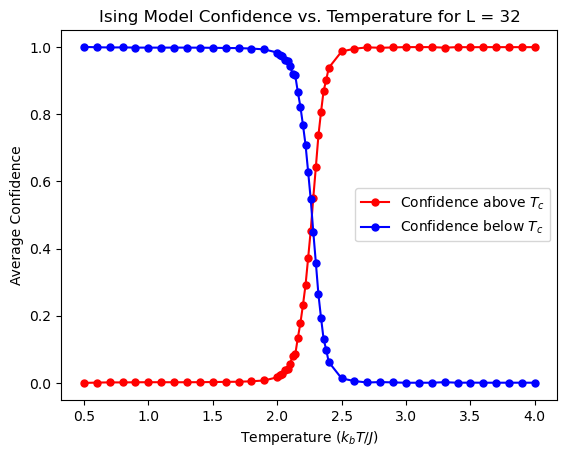

In [29]:
plt.plot(TEMP_VALS, confidence_above_ising32x32, label="Confidence above $T_{c}$", marker=".", markersize=10, color="r")
plt.plot(TEMP_VALS, confidence_below_ising32x32, label="Confidence below $T_{c}$", marker=".", markersize=10, color="b")
plt.title("Ising Model Confidence vs. Temperature for L = 32")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Average Confidence")
plt.legend()
#plt.savefig("ising_confidence_vs_t.png")
plt.show()

## Produce Magnetization Plot

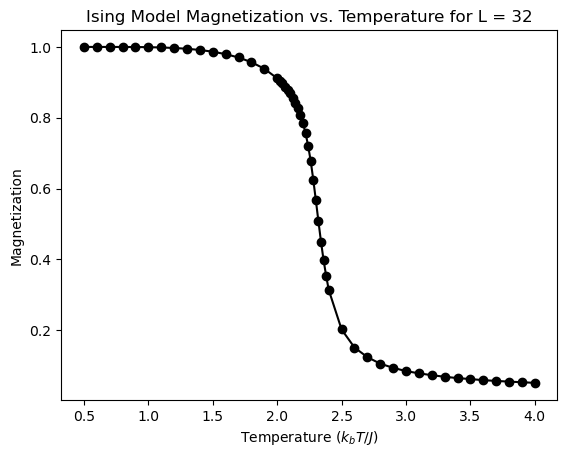

In [4]:
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full32x32"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000

file_string = "../data/bins/bins_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_magnetization_vals = np.zeros(shape=(NUM_TEMPS, NUM_BINS))
magnetization_errors = np.zeros(NUM_TEMPS)

data_dict = {}

# extract magnetization values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):
        raw_magnetization_vals[temp][bin] = float(data[(temp * NUM_BINS) + bin][-1])

    data_dict[TEMP_VALS[temp]] = np.mean(raw_magnetization_vals[temp])
    magnetization_errors[temp] = np.std(raw_magnetization_vals[temp]) / np.sqrt(NUM_BINS)

temps = []
magnetizations = []

# iterate through dictionary of data to facilitate plotting
for temp, magnetization in data_dict.items():
    temps.append(temp)
    magnetizations.append(magnetization)

magnetization_vals_32 = magnetizations
magnetizations_errors_32 = magnetization_errors

plt.errorbar(temps, magnetizations, magnetization_errors, marker=".", markersize=12, color="k")
plt.title("Ising Model Magnetization vs. Temperature for L = 32")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Magnetization")
#plt.savefig('ising_magnetization_L=4.png')
plt.show()

# L = 64

In [30]:
class_names = ['Below T_c', 'Above T_c']
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full64x64"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000
TRAIN_BINS = int(0.8 * NUM_BINS)
TEST_BINS = int(0.2 * NUM_BINS)
NUM_TRAIN = int(TRAIN_BINS * NUM_TEMPS)
NUM_TEST = int(TEST_BINS * NUM_TEMPS)

L = 64

file_string = "../data/spinconfigs/spinConfigs_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_spin_configs = np.zeros(shape=(NUM_TEMPS, NUM_BINS, L, L))

data_dict = {}

# initialize data dictionary
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = []

# convert -1s to 0s
for entry in data:
    for index in range(L*L):
        if entry[index] == -1:
            entry[index] = 0

# extract spin configs values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):            
        raw_spin_configs[temp][bin] = data[(temp * NUM_BINS) + bin].reshape(L, L)

# populate data dictionary with numpy array of temps
for temp in range(NUM_TEMPS):
    data_dict[TEMP_VALS[temp]] = raw_spin_configs[temp]

# initialize arrays for training and testing images and labels
train_images = np.zeros(shape=(NUM_TRAIN, L, L))
shuffled_images = train_images

train_labels = np.zeros(NUM_TRAIN, dtype=int)
shuffled_labels = train_labels

test_images = np.zeros(shape=(NUM_TEST, L, L))
shuffled_test_images = test_images

test_labels = np.zeros(NUM_TEST, dtype=int)
shuffled_test_labels = test_labels


# populate train images and train labels with spin configs
offset = 0
for temp, array in data_dict.items():
    train_images[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = array[0:TRAIN_BINS]
    test_images[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = array[TRAIN_BINS:]
    
    # if lower than T_c, should be a 0
    if temp < 2.269:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.zeros(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.zeros(TEST_BINS)
    else:
        train_labels[(TRAIN_BINS * offset):(TRAIN_BINS * (offset+1))] = np.ones(TRAIN_BINS)
        test_labels[(TEST_BINS * offset):(TEST_BINS * (offset+1))] = np.ones(TEST_BINS)
    
    offset += 1

# helper function to shuffle pairs of images
def shuffle_pairs(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# shuffle our images and labels according to the same permutation
shuffled_images, shuffled_labels = shuffle_pairs(train_images, train_labels)

# shuffle test images and labels
shuffled_test_images, shuffled_test_labels = shuffle_pairs(test_images, test_labels)

square_data_dict = {}

# reshape dictionary arrays into LxL instead of 
for temp in range(NUM_TEMPS):
    square_data_dict[TEMP_VALS[temp]] = data_dict[TEMP_VALS[temp]].reshape(NUM_BINS, L, L)

In [31]:
import tensorflow as tf

ising64x64model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(L, L)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

ising64x64model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ising64x64model.fit(shuffled_images, shuffled_labels, epochs=20)

Epoch 1/20
6500/6500 [==============================] - 5s 763us/step - loss: 0.5940 - accuracy: 0.7344
Epoch 2/20
6500/6500 [==============================] - 5s 756us/step - loss: 0.1545 - accuracy: 0.9545
Epoch 3/20
6500/6500 [==============================] - 5s 760us/step - loss: 0.1021 - accuracy: 0.9681
Epoch 4/20
6500/6500 [==============================] - 5s 764us/step - loss: 0.0810 - accuracy: 0.9747
Epoch 5/20
6500/6500 [==============================] - 5s 765us/step - loss: 0.0716 - accuracy: 0.9770
Epoch 6/20
6500/6500 [==============================] - 5s 792us/step - loss: 0.0623 - accuracy: 0.9797
Epoch 7/20
6500/6500 [==============================] - 5s 804us/step - loss: 0.0568 - accuracy: 0.9821
Epoch 8/20
6500/6500 [==============================] - 5s 807us/step - loss: 0.0516 - accuracy: 0.9829
Epoch 9/20
6500/6500 [==============================] - 5s 732us/step - loss: 0.0471 - accuracy: 0.9843
Epoch 10/20
6500/6500 [==============================] - 5s 762u

In [32]:
ising64x64model.save("ising64x64.keras")

In [34]:
test_loss, test_acc = ising64x64model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([ising64x64model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

raw_confidence_above_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))
raw_confidence_below_vals = np.zeros(shape=(NUM_TEMPS, TEST_BINS))

confidence_above_ising64x64 = []
confidence_below_ising64x64 = []
error_above_ising64x64 = []
error_below_ising64x64 = []

for temp in range(NUM_TEMPS):
    for bin in range(TEST_BINS):
        raw_confidence_above_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][1])
        raw_confidence_below_vals[temp][bin] = float(predictions[(temp * TEST_BINS) + bin][0])

    error_above_ising64x64.append(np.std(raw_confidence_above_vals[temp]) / np.sqrt(TEST_BINS))
    error_below_ising64x64.append(np.std(raw_confidence_below_vals[temp]) / np.sqrt(TEST_BINS))
    
    confidence_above_ising64x64.append(np.mean(raw_confidence_above_vals[temp]))
    confidence_below_ising64x64.append(np.mean(raw_confidence_below_vals[temp]))

1625/1625 - 1s - loss: 0.2080 - accuracy: 0.9682

Test accuracy: 0.9682307839393616


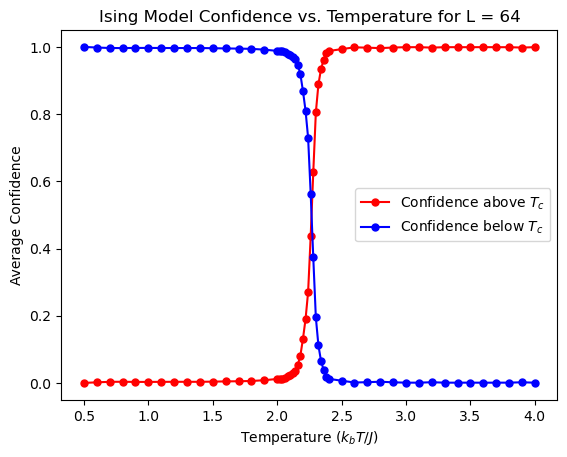

In [35]:
plt.plot(TEMP_VALS, confidence_above_ising64x64, label="Confidence above $T_{c}$", marker=".", markersize=10, color="r")
plt.plot(TEMP_VALS, confidence_below_ising64x64, label="Confidence below $T_{c}$", marker=".", markersize=10, color="b")
plt.title("Ising Model Confidence vs. Temperature for L = 64")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Average Confidence")
plt.legend()
# plt.savefig("ising_confidence_vs_t_64x64.png", dpi=500)
plt.show()

## Produce Magnetization Plot

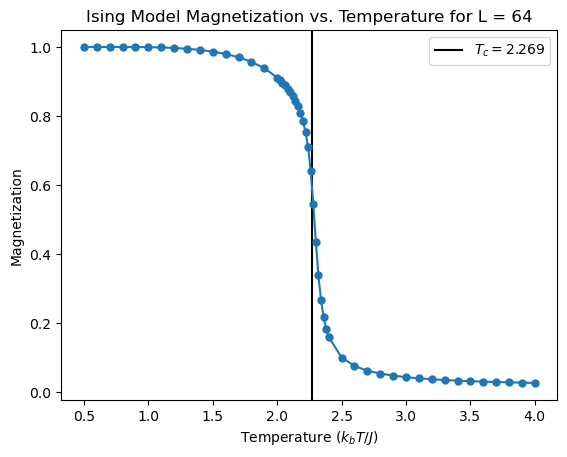

In [5]:
import matplotlib.pyplot as plt
import numpy as np

FILENAME = "isingvsT_full64x64"

TEMP_VALS = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.02, 2.04, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16, 2.18, 2.20, 2.22, 2.24, 2.26, 2.28, 2.3, 2.32, 2.34, 2.36, 2.38, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
NUM_TEMPS = len(TEMP_VALS)
NUM_BINS = 5000

file_string = "../data/bins/bins_" + FILENAME + ".txt"

data = np.loadtxt(file_string)

raw_magnetization_vals = np.zeros(shape=(NUM_TEMPS, NUM_BINS))
magnetization_errors = np.zeros(NUM_TEMPS)

data_dict = {}

# extract magnetization values 
for temp in range(NUM_TEMPS):
    for bin in range(NUM_BINS):
        raw_magnetization_vals[temp][bin] = float(data[(temp * NUM_BINS) + bin][-1])

    data_dict[TEMP_VALS[temp]] = np.mean(raw_magnetization_vals[temp])
    magnetization_errors[temp] = np.std(raw_magnetization_vals[temp]) / np.sqrt(NUM_BINS)

temps = []
magnetizations = []

# iterate through dictionary of data to facilitate plotting
for temp, magnetization in data_dict.items():
    temps.append(temp)
    magnetizations.append(magnetization)

magnetization_vals_64 = magnetizations
magnetizations_errors_64 = magnetization_errors

plt.errorbar(temps, magnetizations, magnetization_errors, marker=".", markersize=10)
plt.title("Ising Model Magnetization vs. Temperature for L = 64")
plt.axvline(x = 2.269, color = 'k', label="$T_{c} = 2.269$")
plt.legend()
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Magnetization")
# plt.savefig('ising_magnetization_L=64.png', dpi=500)
plt.show()

# Produce combined magnetization plot

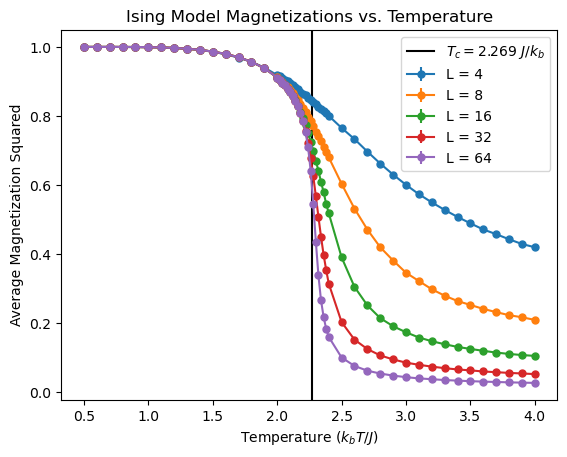

In [7]:
plt.errorbar(temps, magnetization_vals_4, magnetizations_errors_4, marker=".", markersize=10, label="L = 4")
plt.errorbar(temps, magnetization_vals_8, magnetizations_errors_8, marker=".", markersize=10, label="L = 8")
plt.errorbar(temps, magnetization_vals_16, magnetizations_errors_16, marker=".", markersize=10, label="L = 16")
plt.errorbar(temps, magnetization_vals_32, magnetizations_errors_32, marker=".", markersize=10, label="L = 32")
plt.errorbar(temps, magnetization_vals_64, magnetizations_errors_64, marker=".", markersize=10, label="L = 64")
plt.axvline(x = 2.269, color = 'k', label="$T_{c} = 2.269 \ J/k_{b}$")
plt.legend()
plt.title("Ising Model Magnetizations vs. Temperature")
plt.xlabel("Temperature ($k_{b}T/J$)")
plt.ylabel("Average Magnetization Squared")
plt.savefig('ising_magnetizations_full.png', dpi=500)
plt.show()

In [37]:
import pickle


# Saving the objects:
with open('isingvariables.pkl', 'wb') as file:  # Python 3: open(..., 'wb')
    pickle.dump([confidence_above_ising4x4, error_above_ising4x4, confidence_below_ising4x4, error_below_ising4x4,
                 confidence_above_ising8x8, error_above_ising8x8, confidence_below_ising8x8, error_below_ising8x8,
                 confidence_above_ising16x16, error_above_ising16x16, confidence_below_ising16x16, error_below_ising16x16,
                 confidence_above_ising32x32, error_above_ising32x32, confidence_below_ising32x32, error_below_ising32x32,
                 confidence_above_ising64x64, error_above_ising64x64, confidence_below_ising64x64, error_below_ising64x64],
                file)